# generator

용량이 큰 파일을 나눠서 가져와서(index 기준, batch_size 크기만큼) 학습

index 셔플, 슬라이싱, 스플릿

스플릿 기능이 중첩되면 오류나므로 'validation_split=0.1'는 제거 후 돌려야함

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Input, Dense, Flatten

import time

# 데이터 준비

In [2]:
(raw_train_x, raw_train_y), (raw_test_x, raw_test_y) = tf.keras.datasets.mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [3]:
print(raw_train_x.shape)
print(raw_train_y.shape)
print(raw_test_x.shape)
print(raw_test_y.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


In [4]:
# 데이터 나눠주기
i = int(len(raw_train_x)*0.8)
raw_train_x, raw_valid_x = raw_train_x[:i], raw_train_x[i:]
raw_train_y, raw_valid_y = raw_train_y[:i], raw_train_y[i:]

In [5]:
print(raw_train_x.shape)
print(raw_train_y.shape)
print(raw_valid_x.shape)
print(raw_valid_y.shape)
print(raw_test_x.shape)
print(raw_test_y.shape)

(48000, 28, 28)
(48000,)
(12000, 28, 28)
(12000,)
(10000, 28, 28)
(10000,)


In [7]:
import numpy as np
import math
from tensorflow.keras.utils import Sequence
from abc import *
import traceback

BATCH_SIZE = 32

class DataGenerator(Sequence):

  def __init__(self, org_image, org_label, batch_size=BATCH_SIZE, shuffle=True):
    self.org_image = org_image/255.
    self.org_label = org_label
    self.batch_size = batch_size
    self.shuffle=shuffle
    self.on_epoch_end()

# __len__: 전체 데이터를 몇번 꺼낼수 있는지
  def __len__(self):
    return math.ceil(len(self.org_image) / self.batch_size)

# __getitem__: 인덱스 섞어줌
  def __getitem__(self, idx):
    indices = self.indices[idx*self.batch_size:(idx+1)*self.batch_size]
    batch_x = [self.org_image[i] for i in indices]
    batch_y = [self.org_label[i] for i in indices]
    return np.array(batch_x), np.array(batch_y)

  def on_epoch_end(self):
    self.indices = np.arange(len(self.org_image))
    if self.shuffle == True:
      np.random.shuffle(self.indices)

In [8]:
train_data_generator = DataGenerator(raw_train_x, raw_train_y)
valid_data_generator = DataGenerator(raw_valid_x, raw_valid_y)
test_data_generator = DataGenerator(raw_test_x, raw_test_y)

(32, 28, 28)
(32,)
4


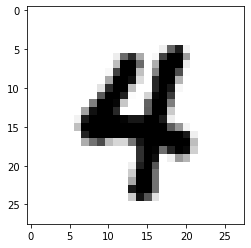

In [9]:
batch_x, batch_y = train_data_generator.__getitem__(0)

print(batch_x.shape)
print(batch_y.shape)

plt.imshow(batch_x[0], cmap=plt.cm.binary)
print(batch_y[0])

In [10]:
model = keras.Sequential()
model.add(Input((28,28)))  # ADD
model.add(Flatten())       # ADD
model.add(Dense(10, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.summary()


model.fit(train_data_generator, validation_data=valid_data_generator, epochs=5, verbose=1, batch_size=128)


loss, acc = model.evaluate(test_data_generator)
print("loss=",loss)
print("acc=",acc)

batch_x, batch_y = test_data_generator.__getitem__(0)
y_ = model.predict(batch_x)
predicted = np.argmax(y_, axis=1)

print(predicted)

y_ = model.predict(test_data_generator)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 10)                7850      
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 10)                110       
                                                                 
Total params: 8,070
Trainable params: 8,070
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
1500/1500 [==============================] - 8s 4ms/step - loss: 0.6472 - accuracy: 0.8044 - val_loss: 0.3389 - val_accuracy: 0.9033
Epoch 2/5
1500/1500 [======================